In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### **what I did in this notebook:**  This notebook reproduces the preprocessing and Fourier‑feature mapping used in training, loads saved scalers and model if available, runs a small reproducible evaluation on a held‑out sample, computes MSE/MAE, and produces diagnostic plots (true vs predicted, residuals, y vs x).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("/kaggle/input/train-data1/train_data.csv")
dataset.head()

,w,x,y
0,-2.5,-2.784390,0.596025
1,-2.5,-2.308732,-0.449801
2,-2.5,-3.869936,-0.301154
3,-2.5,-2.671678,0.399640
4,-2.5,6.609344,0.700448


In [3]:
dataset.shape

(100000000, 3)

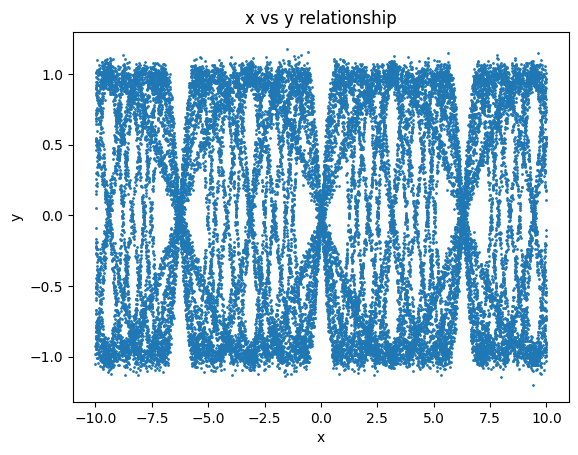

In [4]:
sample = dataset.sample(30000)
plt.scatter(sample['x'], sample['y'], s=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y relationship')
plt.show()


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler



2025-10-23 13:19:31.352437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761225571.543010      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761225571.593886      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os, gc, joblib


file_path = "/kaggle/input/train-data1/train_data.csv"
model_path = "/kaggle/working/pattern_model_fourier_final.h5"
scaler_x_path = "/kaggle/working/scaler_x.pkl"
scaler_y_path = "/kaggle/working/scaler_y.pkl"

subset = pd.read_csv(file_path, nrows=100_000)
scaler_x = StandardScaler().fit(subset[['w', 'x']].values)
scaler_y = StandardScaler().fit(subset[['y']].values)

joblib.dump(scaler_x, scaler_x_path)
joblib.dump(scaler_y, scaler_y_path)
del subset; gc.collect()

def add_fourier_features(X, num_frequencies=8, scale=5.0):
    np.random.seed(42)
    B = np.random.normal(scale=scale, size=(X.shape[1], num_frequencies))
    X_proj = 2 * np.pi * X @ B
    return np.concatenate([np.sin(X_proj), np.cos(X_proj)], axis=-1)

tmp = add_fourier_features(np.zeros((1, 2)))
input_dim = tmp.shape[1]
print(f"Input dimension after Fourier features: {input_dim}")

def create_fourier_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='mse',
        metrics=['mae']
    )
    return model

model = create_fourier_model(input_dim)
model.summary()

chunk_size = 2_000_000   
epochs_per_chunk = 15
batch_size = 8192

for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunk_size)):
    X_raw = chunk[['w', 'x']].values
    y_raw = chunk[['y']].values
    X_scaled = scaler_x.transform(X_raw)
    X_ff = add_fourier_features(X_scaled)
    y_scaled = scaler_y.transform(y_raw)
    
    model.fit(
        X_ff, y_scaled,
        epochs=epochs_per_chunk,
        batch_size=batch_size,
        verbose=1
    )



Input dimension after Fourier features: 16


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 435,713 (1.66 MB)

 Trainable params: 435,713 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2228 - mae: 0.3048
Epoch 2/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0563
Epoch 3/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0562
Epoch 4/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0562
Epoch 5/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0562
Epoch 6/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0562
Epoch 7/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0562
Epoch 8/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0563
Epoch 9/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0563
Epoch 10/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0562
Epoch 11/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0564
Epoch 12/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0050 - mae: 0.0563
Epoch 13/15
245/245 ━━━━━

MAE = 0.988295


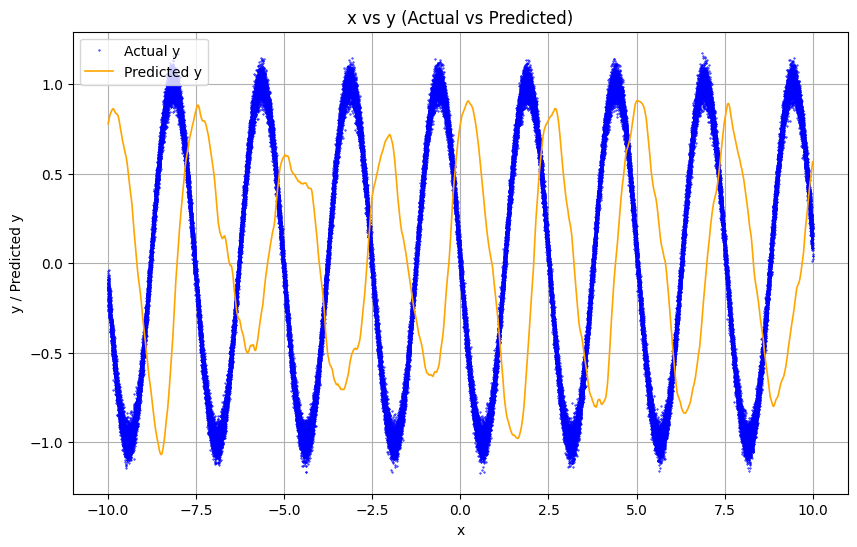

In [12]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = load_model(model_path, compile=False)
scaler_x = joblib.load(scaler_x_path)
scaler_y = joblib.load(scaler_y_path)

df = pd.read_csv(file_path, nrows=100_000)

X_scaled = scaler_x.transform(df[['w', 'x']].values)
X_ff = add_fourier_features(X_scaled)
y_true = df['y'].values

y_pred_scaled = model.predict(X_ff, batch_size=100_000, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"MAE = {mae:.6f}")

df['y_pred'] = y_pred
df_sorted = df.sort_values('x')

plt.figure(figsize=(10,6))
plt.plot(df_sorted['x'], df_sorted['y'], '*', markersize=1.2,
         color='blue', alpha=0.5, label='Actual y')
plt.plot(df_sorted['x'], df_sorted['y_pred'], '-', linewidth=1.2,
         color='orange', label='Predicted y')
plt.xlabel("x")
plt.ylabel("y / Predicted y")
plt.title("x vs y (Actual vs Predicted)")
plt.legend()
plt.grid(True)
plt.show()
